In [ ]:
import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET

from pathlib import Path
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pip install opencv-python
#pip install scikit-learn

In [ ]:
!unzip -uq "/content/drive/MyDrive/archive (3).zip" -d "/content/drive/My Drive/archive (3)_output"

In [ ]:
#Loading the data¶

images_path = Path('/content/drive/MyDrive/archive (3)/images')
anno_path = Path('/content/drive/MyDrive/archive (3)/annotations')
print(images_path)

/content/drive/MyDrive/archive (3)/images


In [ ]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [ ]:
def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot() # module implements a simple and efficient API for parsing and creating XML
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [ ]:

df_train = generate_train_df(anno_path)

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/archive (3)/images/road...,267,400,trafficlight,98,62,208,232
1,/content/drive/MyDrive/archive (3)/images/road...,400,283,trafficlight,154,63,258,281
2,/content/drive/MyDrive/archive (3)/images/road...,400,267,trafficlight,106,3,244,263
3,/content/drive/MyDrive/archive (3)/images/road...,400,246,speedlimit,174,128,186,139
4,/content/drive/MyDrive/archive (3)/images/road...,400,364,speedlimit,48,14,344,345


In [ ]:
#label encode target- creating dict data type the keys are the class value and the value are the num encoder
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}



In [ ]:
# coding the class column with a numerical value
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [ ]:
print(df_train.shape)
df_train.info()

(877, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  877 non-null    object
 1   width     877 non-null    object
 2   height    877 non-null    object
 3   class     877 non-null    int64 
 4   xmin      877 non-null    int64 
 5   ymin      877 non-null    int64 
 6   xmax      877 non-null    int64 
 7   ymax      877 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 54.9+ KB


In [ ]:
#Reading an image
def read_image(path):
    return cv2.imread(str(path))

In [ ]:
def resize_image(read_path,write_path,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    #im_resized = cv2.resize(im, (224, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path,im_resized)
    return new_path

In [ ]:
#Populating Training DF with new paths and bounding boxes
new_paths = []

train_path_resized = Path('/content/drive/MyDrive/archive (3)/new_path')
for index, row in df_train.iterrows():
    new_path = resize_image(row['filename'], train_path_resized,224)

    new_paths.append(new_path)


df_train['new_path'] = new_paths


In [ ]:

#Sample Image¶

im = cv2.imread(str(df_train.values[0][0]))


In [ ]:
print(im.shape)

(400, 267, 3)


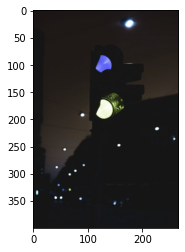

In [ ]:
plt.imshow(im)

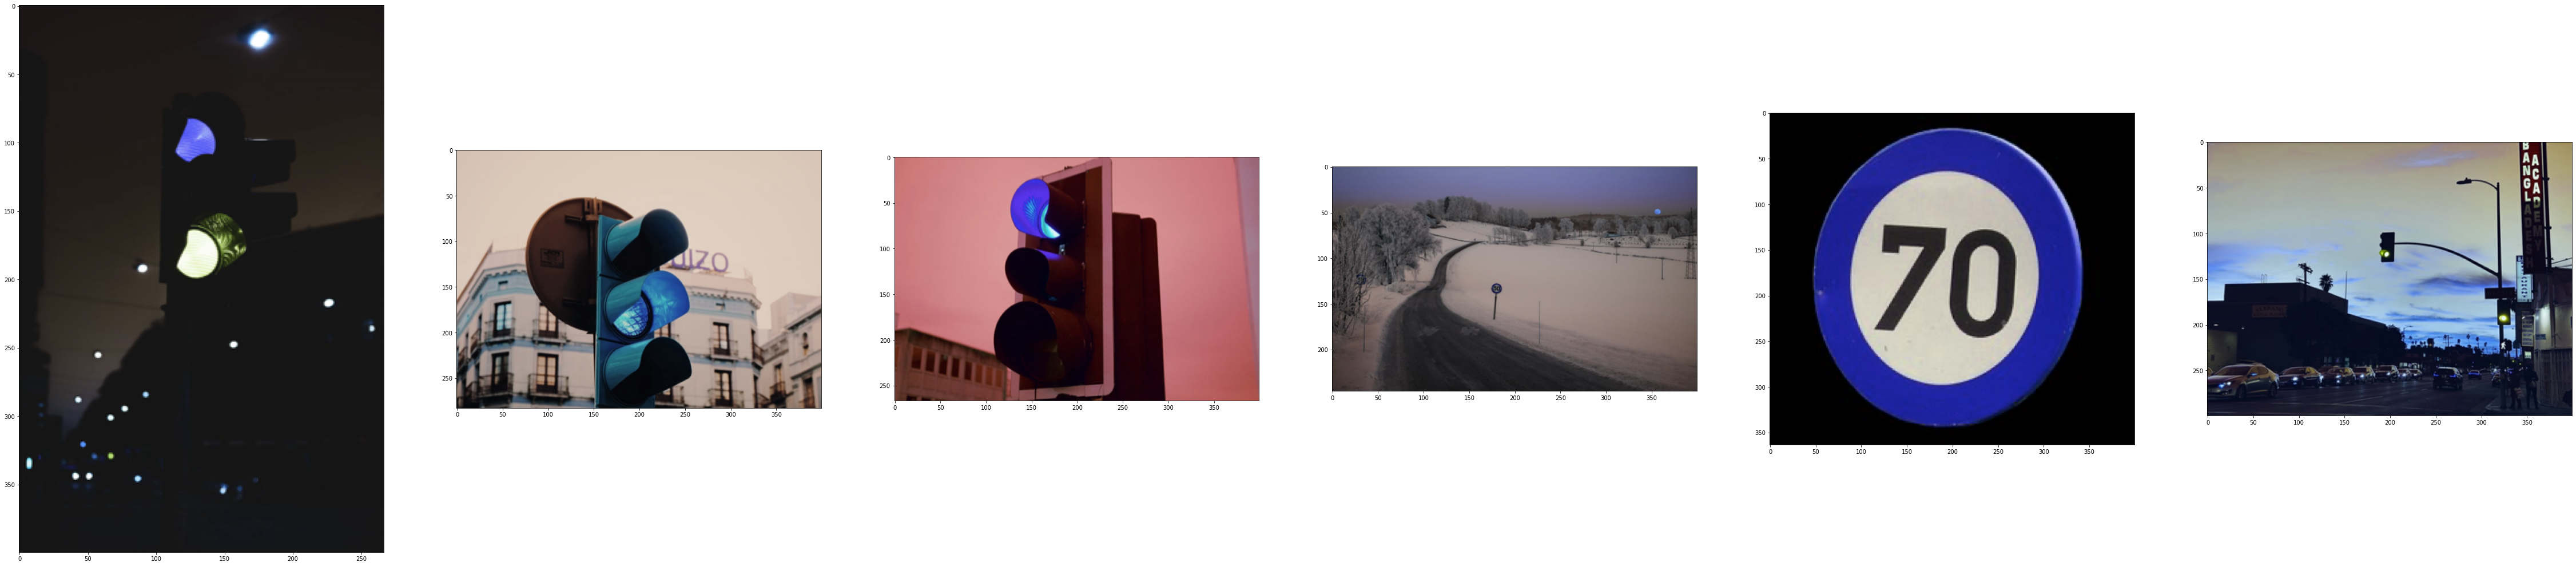

In [ ]:
N=6
f, ax = plt.subplots(1, N)
f.set_size_inches(80, 40)
for i in range(N):
     ax[i].imshow(cv2.imread(str(df_train.values[i][0])))
plt.show()



In [ ]:
df_train1 = df_train.reset_index()

#DataFrame.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')[source]¶
#For DataFrame with multi-level index, return new DataFrame with labeling information in
#the columns under the index names, defaulting to ‘level_0’, ‘level_1’, etc. if any are None.
#For a standard index, the index name will be used (if set), otherwise a default
#‘index’ or ‘level_0’ (if ‘index’ is already taken) will be used.


In [ ]:
X = df_train1[['new_path']]
y = df_train1['class']
y.head()

0    3
1    3
2    3
3    0
4    0
Name: class, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)

In [ ]:

im2 = cv2.imread(str(X_train.values[50][0]))

In [ ]:
im2.shape

(224, 224, 3)

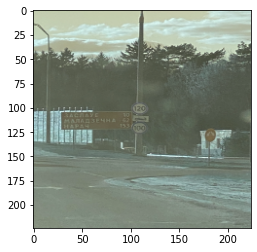

In [ ]:
plt.imshow(im2)

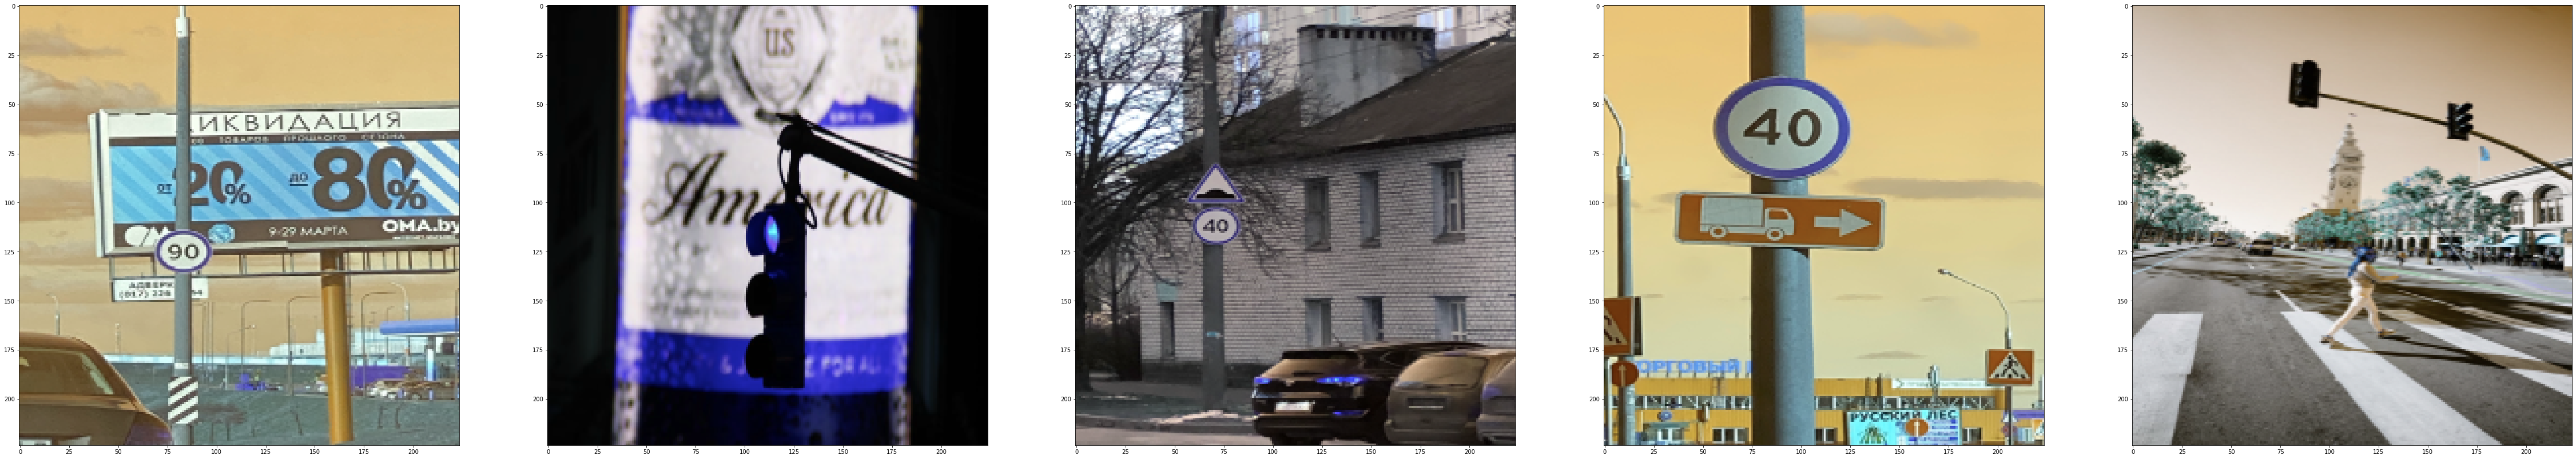

In [ ]:
N=5
f, ax = plt.subplots(1, N)
f.set_size_inches(80, 40)
for i in range(N):
     ax[i].imshow(cv2.imread(str(X_test.values[i][0])))
plt.show()

In [ ]:
#predecting

In [ ]:
import tensorflow as tf

from tensorflow import keras
from keras import Sequential, layers, optimizers
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils



In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing import image

def prepare_image(img):
    img_array = image.img_to_array(img)
    #im_resized = cv2.resize(im, (224, 224))
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    print (img_array_expanded_dims)
    print (img_array_expanded_dims.shape)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
im2_processed= prepare_image(im2)

[[[[192. 205. 172.]
   [194. 204. 174.]
   [193. 204. 173.]
   ...
   [197. 222. 212.]
   [198. 222. 213.]
   [198. 222. 213.]]

  [[193. 204. 173.]
   [194. 203. 175.]
   [194. 203. 174.]
   ...
   [200. 225. 217.]
   [201. 226. 218.]
   [201. 226. 219.]]

  [[196. 206. 177.]
   [195. 204. 176.]
   [195. 204. 177.]
   ...
   [191. 215. 207.]
   [193. 217. 210.]
   [196. 221. 213.]]

  ...

  [[137. 147. 129.]
   [135. 145. 129.]
   [131. 140. 124.]
   ...
   [120. 132. 121.]
   [119. 131. 120.]
   [119. 130. 119.]]

  [[136. 146. 129.]
   [134. 144. 127.]
   [135. 145. 128.]
   ...
   [120. 134. 122.]
   [120. 133. 122.]
   [121. 135. 124.]]

  [[129. 142. 124.]
   [133. 145. 128.]
   [133. 145. 127.]
   ...
   [131. 147. 133.]
   [127. 142. 129.]
   [120. 136. 122.]]]]
(1, 224, 224, 3)


In [ ]:
im2_processed.shape

(1, 224, 224, 3)

In [ ]:
predictions = mobile.predict(im2_processed)

1/1 [==============================] - 0s 70ms/step


In [ ]:
results = imagenet_utils.decode_predictions(predictions)
results

[[('n04149813', 'scoreboard', 0.44308385),
  ('n03355925', 'flagpole', 0.20837368),
  ('n04266014', 'space_shuttle', 0.035377223),
  ('n03393912', 'freight_car', 0.025415294),
  ('n03976657', 'pole', 0.017965496)]]

In [ ]:

from tensorflow.keras.applications import vgg16

vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step
